<a href="https://colab.research.google.com/github/klebster2/mms-colab/blob/main/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers torch torchaudio jiwer librosa soundfile requests

import torch
import torchaudio
import librosa
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
from transformers import Wav2Vec2ForCTC, AutoProcessor
import jiwer
import requests
import io
from IPython.display import Audio, display
import warnings
warnings.filterwarnings('ignore')

print("✅ All packages installed successfully!")

✅ All packages installed successfully!


In [9]:
def download_audio(url, filename):
    """Download audio file from URL with proper User-Agent for Wikimedia"""
    try:
        headers = {
            'User-Agent': 'MMS-ASR-Demo/1.0 (https://colab.research.google.com; educational-demo) Python/requests'
        }
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        with open(filename, 'wb') as f:
            f.write(response.content)
        print(f"✅ Downloaded: {filename}")
        return True
    except Exception as e:
        print(f"❌ Error downloading {filename}: {e}")
        print(f"🔄 Trying alternative download method...")
        return False

audio_samples = {
    "German": [
        {
          "url": "https://upload.wikimedia.org/wikipedia/commons/0/0d/CPIDL_German_-_Hallo.ogg",
          "filename": "de_hallo.ogg",
          "expected_text": "hallo",
          "language": "German",
          "lang_code": "deu"  # ISO 639-3 code for MMS
        },
        {
            "url": "https://upload.wikimedia.org/wikipedia/commons/5/5a/De-jetzt.ogg",
            "filename": "de_jetzt.ogg",
            "expected_text": "jetzt",
            "language": "German",
            "lang_code": "deu"
        }
    ]
}

print("📥 Downloading Wiktionary audio samples...")
for lang, samples in audio_samples.items():
  for info in samples:
    download_audio(info["url"], info["filename"])

📥 Downloading Wiktionary audio samples...
✅ Downloaded: de_hallo.ogg
✅ Downloaded: de_jetzt.ogg


In [10]:
print("\n🚀 Loading Facebook's MMS-1B-All model (1000+ languages)...")

class MMSMultilingualASR:
    def __init__(self) -> None:
        model_id = "facebook/mms-1b-all"
        self._processor = AutoProcessor.from_pretrained(
            pretrained_model_name_or_path=model_id
        )
        self._model = Wav2Vec2ForCTC.from_pretrained(
            pretrained_model_name_or_path=model_id
        )

        # Move to GPU if available
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self._model = self._model.to(self.device)

        print(f"MMS-1B-All model loaded on: {self.device}")

    def set_language(self, language_code):
        """Set the target language for ASR"""
        self._processor.tokenizer.set_target_lang(language_code)
        self._model.load_adapter(language_code)
        print(f"Language adapter loaded: {language_code}")

    def transcribe(self, audio, sampling_rate=16000):
        """Transcribe audio using MMS model"""
        # Preprocess audio
        inputs = self._processor(audio, sampling_rate=sampling_rate, return_tensors="pt")

        # Move to device
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        # Inference
        with torch.no_grad():
            logits = self._model(**inputs).logits

        # Decode predictions
        predicted_ids = torch.argmax(logits, dim=-1)
        transcription = self._processor.batch_decode(predicted_ids)[0]

        # Get confidence scores
        probs = torch.nn.functional.softmax(logits, dim=-1)
        confidence = torch.max(probs, dim=-1)[0].mean().item()

        return transcription.lower().strip(), confidence

# Initialize the MMS model
mms_asr = MMSMultilingualASR()


🚀 Loading Facebook's MMS-1B-All model (1000+ languages)...
MMS-1B-All model loaded on: cuda


In [15]:
def load_and_preprocess_audio(filename, target_sr=16000):
    """Load audio file and preprocess for Wav2Vec2"""
    audio, sr = librosa.load(filename, sr=target_sr)
    if len(audio.shape) > 1:
        audio = librosa.to_mono(audio)

    audio = audio / np.max(np.abs(audio))

    return audio, sr

def visualize_audio(audio, sr, title):
    """Visualize audio waveform"""
    plt.figure(figsize=(6, 2))
    time = np.linspace(0, len(audio) / sr, len(audio))
    plt.plot(time, audio)
    plt.title(f"Audio Waveform: {title}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def transcribe_audio_mms(audio, mms_model, lang_code):
    """Transcribe audio using MMS model with language-specific adapter"""
    mms_model.set_language(lang_code)
    transcription, confidence = mms_model.transcribe(audio)

    return transcription, confidence

In [18]:
def evaluate_asr_sample(sample_info, mms_model):
    """Complete ASR evaluation for a single sample using MMS"""
    filename = sample_info["filename"]
    expected = sample_info["expected_text"].lower()
    language = sample_info["language"]
    lang_code = sample_info["lang_code"]

    print(f"\n{'='*60}")
    print(f"EVALUATING {language.upper()} ASR (Language Code: {lang_code})")
    print(f"{'='*60}")
    print(f"File: {filename}")
    print(f"Expected: '{expected}'")

    audio, sr = load_and_preprocess_audio(filename)
    print(f"Audio loaded: {len(audio)} samples at {sr}Hz ({len(audio)/sr:.2f}s)")

    display(Audio(audio, rate=sr))

    # Visualize waveform
    visualize_audio(audio, sr, f"{language} - {expected}")

    print(f"\nTranscribing with MMS language adapter: {lang_code}")
    hypothesis, confidence = transcribe_audio_mms(audio, mms_model, lang_code)

    wer_score = jiwer.wer(expected, hypothesis)
    cer_score = jiwer.cer(expected, hypothesis)

    # Results
    print(f"\n RESULTS:")
    print(f"   Language:   {language} ({lang_code})")
    print(f"   Expected:   '{expected}'")
    print(f"   Predicted:  '{hypothesis}'")
    print(f"   Confidence: {confidence:.4f}")
    print(f"   WER:        {wer_score:.4f} ({wer_score*100:.2f}%)")
    print(f"   CER:        {cer_score:.4f} ({cer_score*100:.2f}%)")

    # Error analysis
    if wer_score == 0:
        print(" Perfect transcription!")
    else:
        print(f"  Transcription errors detected")
        # Show detailed comparison
        print(f"\nDetailed comparison:")
        print(f"Expected: {list(expected)}")
        print(f"Got:      {list(hypothesis)}")

    return {
        "language": language,
        "lang_code": lang_code,
        "expected": expected,
        "hypothesis": hypothesis,
        "wer": wer_score,
        "cer": cer_score,
        "confidence": confidence,
        "audio_duration": len(audio)/sr
    }


EVALUATING GERMAN ASR (Language Code: deu)
File: de_hallo.ogg
Expected: 'hallo'
Audio loaded: 7617 samples at 16000Hz (0.48s)


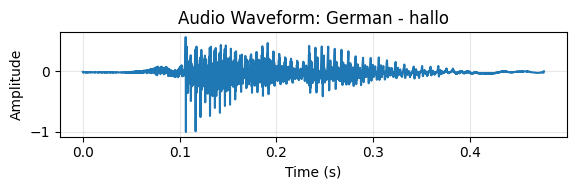


Transcribing with MMS language adapter: deu
Language adapter loaded: deu

 RESULTS:
   Language:   German (deu)
   Expected:   'hallo'
   Predicted:  'hallo'
   Confidence: 0.9769
   WER:        0.0000 (0.00%)
   CER:        0.0000 (0.00%)
 Perfect transcription!

EVALUATING GERMAN ASR (Language Code: deu)
File: de_jetzt.ogg
Expected: 'jetzt'
Audio loaded: 15047 samples at 16000Hz (0.94s)


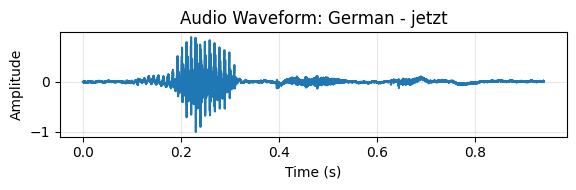


Transcribing with MMS language adapter: deu
Language adapter loaded: deu

 RESULTS:
   Language:   German (deu)
   Expected:   'jetzt'
   Predicted:  'jetzt'
   Confidence: 0.9614
   WER:        0.0000 (0.00%)
   CER:        0.0000 (0.00%)
 Perfect transcription!

COMPREHENSIVE ASR EVALUATION RESULTS
Language   Code   Expected     Predicted    WER      CER      Confidence  
-------------------------------------------------------------------------------------
German     deu    hallo        hallo        0.0000   0.0000   0.9769
German     deu    jetzt        jetzt        0.0000   0.0000   0.9614
-------------------------------------------------------------------------------------
AVERAGE                                     0.0000   0.0000


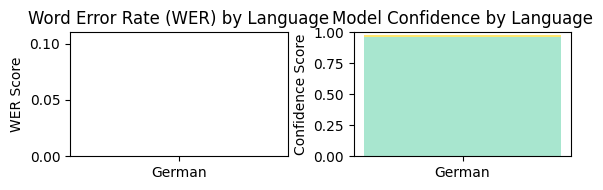

In [21]:
# Run evaluation on both samples
results = []

for lang, samples in audio_samples.items():
    for sample_info in samples:
        result = evaluate_asr_sample(sample_info, mms_asr)
        if result:
            results.append(result)

print(f"\n{'='*80}")
print("COMPREHENSIVE ASR EVALUATION RESULTS")
print(f"{'='*80}")

if results:
    print(f"{'Language':<10} {'Code':<6} {'Expected':<12} {'Predicted':<12} {'WER':<8} {'CER':<8} {'Confidence':<12}")
    print("-" * 85)

    total_wer = 0
    total_cer = 0

    for result in results:
        print(f"{result['language']:<10} {result['lang_code']:<6} {result['expected']:<12} {result['hypothesis']:<12} "
              f"{result['wer']:.4f}   {result['cer']:.4f}   {result['confidence']:.4f}")
        total_wer += result['wer']
        total_cer += result['cer']

    print("-" * 85)
    print(f"{'AVERAGE':<10} {'':<6} {'':<12} {'':<12} {total_wer/len(results):.4f}   {total_cer/len(results):.4f}")

    # Create visualization
    plt.figure(figsize=(6, 2))

    # WER comparison
    plt.subplot(1, 2, 1)
    languages = [r['language'] for r in results]
    wer_scores = [r['wer'] for r in results]
    bars1 = plt.bar(languages, wer_scores, color=['#FF6B6B', '#4ECDC4'])
    plt.title('Word Error Rate (WER) by Language')
    plt.ylabel('WER Score')
    plt.ylim(0, max(wer_scores + [0.1]) * 1.1)

    # Confidence comparison
    plt.subplot(1, 2, 2)
    confidence_scores = [r['confidence'] for r in results]
    bars2 = plt.bar(languages, confidence_scores, color=['#FFE66D', '#A8E6CF'])
    plt.title('Model Confidence by Language')
    plt.ylabel('Confidence Score')
    plt.ylim(0, 1)


    plt.tight_layout()
    plt.show()

In [12]:
def test_custom_audio(file_path, expected_text, language_name):
    """Test ASR on custom audio file - useful for live demo"""
    print(f"\nTesting custom audio: {file_path}")
    audio, sr = load_and_preprocess_audio(file_path)
    display(Audio(audio, rate=sr))

    hypothesis, confidence = transcribe_audio(audio, processor, model, device)
    wer_score = jiwer.wer(expected_text, hypothesis)

    print(f"Expected: '{expected_text}'")
    print(f"Got: '{hypothesis}'")
    print(f"WER: {wer_score:.4f}")
    print(f"Confidence: {confidence:.4f}")

    return hypothesis, wer_score, confidence